# Cart-pole swing-up interactive demonstration

Hello and welcome. This is a Jupyter Notebook, a kind of document that can alternate between static content, like text and images, and executable cells of code.

This document ilustrates the Cart-pole swing-up test case of the Collocation Methods for Second Order Systems paper.

In order to run the cells of code, you can select the cell and clic on the small "play" button in the bar above. Alternatively, you can select the option "run -> run all cells" in order to run all the code in order. Beware that some cells can take several minutes!

## Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from optibot.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from optibot.numpy import unpack

In [4]:
from functools import lru_cache

In [5]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

### Symbolic Problem Modelling

The first step is to model our problem taking advantage of the high level object syntax of the mechanics module in SymPy

In [6]:
# Creating symbols and dynamic symbols

m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [7]:
# Definition of the physics system

N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

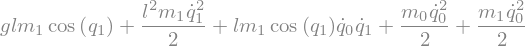

In [8]:
#Computing the Lagrangian

Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [9]:
# Defining the control forces and external actions, and applying them to our system

u0, u1 = symbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


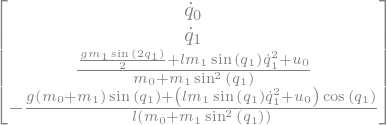

In [10]:
# Generating the dynamic equations

LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

num_pinv_dyn = LM_small.num_pinv_dyn([u0,])

### Casadi optimization

We have generated the system equations symbolicaly. Then, we translate them to CasADi objects in order to perform the optimization.

In [11]:
#Numerical values of the paramenters

m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [12]:
#Package imports

import casadi as cas
from optibot.casadi import rhs_to_casadi_function, restriction2casadi

In [13]:
# Translating the Sympy Expression into a CasADi function

F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [14]:
def gen_ini_guess(N = 25, ini_guess = 'lin'):
    '''
    Generates an initial guess for the Cartpole problem of N intervals.
    '''
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess


In [27]:
import time
def chrono_solve(opti, solve_repetitions):
    '''
    Calls the solver a certain amount of times and returns the last solution
    obtained and the average computing time
    '''
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt



def sol_value(u_arr):
    N = len(u_arr)
    return(np.sum(u_arr[:]**2)+np.sum(u_arr[1:-1]**2))/N

### Scheme definitions

Each scheme is defined here as a function that must be equal to zero at each interval.
Note that functions that contain "mod" in the name are those we define as "second order",
and use separate conditions for q and v.

Schemes that contain "parab" in the name are versions of Hermite Simpson that allow
or $U_c$ to be a free parameter. It is passed to the function through the 
"scheme_params" argument.

If you wish to define your own schemes, do it here.

Be careful to respect the function structure: either

    restriction(x, x_n, u, u_n, F, dt, params) = 0
or
    
    restriction(x, x_n, u, u_n, F, dt, params, scheme_params) = 0

In [28]:
from optibot.schemes import index_div
from copy import copy

def euler_restr(x, x_n, u, u_n, F, dt, params):
    return x_n - (x + dt * F(x, u, params))


def trapz_restr(x, x_n, u, u_n, F, dt, params):
    f = F(x, u, params)
    f_n = F(x_n, u_n, params)
    return x_n - (x + dt / 2 * (f + f_n))


def trapz_mod_restr(x, x_n, u, u_n, F, dt, params):
    res = copy(x)
    first_ind, last_ind = index_div(x)
    q = x[first_ind]
    v = x[last_ind]
    f = F(x, u, params)[last_ind]
    f_n = F(x_n, u_n, params)[last_ind]
    res[last_ind] = v + dt / 2 * (f + f_n)
    res[first_ind] = q + dt * v + dt ** 2 / 6 * (f_n + 2 * f)
    return x_n - res


def hs_restr(x, x_n, u, u_n, F, dt, params):
    f = F(x, u, params)
    f_n = F(x_n, u_n, params)
    x_c = (x + x_n) / 2 + dt / 8 * (f - f_n)
    u_c = (u + u_n) / 2
    f_c = F(x_c, u_c, params)
    return x + dt / 6 * (f + 4 * f_c + f_n) - x_n


def hs_mod_restr(x, x_n, u, u_n, F, dt, params):
    x_c = copy(x)
    res = copy(x)
    first_ind, last_ind = index_div(x)
    f = F(x, u, params)[last_ind]
    f_n = F(x_n, u_n, params)[last_ind]
    q = x[first_ind]
    v = x[last_ind]
    q_n = x_n[first_ind]
    v_n = x_n[last_ind]
    u_c = (u + u_n) / 2
    q_c = q + dt / 32 * (13 * v + 3 * v_n) + dt**2 / 192 * (11 * f - 5 * f_n)
    v_c = (v + v_n) / 2 + dt / 8 * (f - f_n)
    x_c[first_ind] = q_c
    x_c[last_ind] = v_c
    f_c = F(x_c, u_c, params)[last_ind]
    res[last_ind] = v + dt / 6 * (f + 4 * f_c + f_n)
    res[first_ind] = q + dt * v + dt ** 2 / 6 * (f + 2 * f_c)
    return x_n - res


def hs_parab_restr(x, x_n, u, u_n, F, dt, params, scheme_params):
    f = F(x, u, params)
    f_n = F(x_n, u_n, params)
    x_c = (x + x_n) / 2 + dt / 8 * (f - f_n)
    u_c = scheme_params
    f_c = F(x_c, u_c, params)
    return x + dt / 6 * (f + 4 * f_c + f_n) - x_n


def hs_mod_parab_restr(x, x_n, u, u_n, F, dt, params, scheme_params):
    x_c = copy(x)
    res = copy(x)
    first_ind, last_ind = index_div(x)
    f = F(x, u, params)[last_ind]
    f_n = F(x_n, u_n, params)[last_ind]
    q = x[first_ind]
    v = x[last_ind]
    q_n = x_n[first_ind]
    v_n = x_n[last_ind]
    u_c = scheme_params
    q_c = q + dt / 32 * (13 * v + 3 * v_n) + dt**2 / 192 * (11 * f - 5 * f_n)
    v_c = (v + v_n) / 2 + dt / 8 * (f - f_n)
    x_c[first_ind] = q_c
    x_c[last_ind] = v_c
    f_c = F(x_c, u_c, params)[last_ind]
    res[last_ind] = v + dt / 6 * (f + 4 * f_c + f_n)
    res[first_ind] = q + dt * v + dt ** 2 / 6 * (f + 2 * f_c)
    return x_n - res

In [29]:
#@lru_cache
def casadi_cartpole(N = 25, scheme = 'euler', ini_guess = 'lin', solve_repetitions = 1, t_end = 2):
    opti = cas.Opti()
    p_opts = {"expand":True,'ipopt.print_level':0, 'print_time':0}
    s_opts = {"max_iter": 10000, 'tol': 1e-26}
    opti.solver("ipopt",p_opts,
                        s_opts)
    restr_schemes = {
        'euler': euler_restr, # Euler scheme
        'trapz': trapz_restr, # Trapezoidal Scheme
        'trapz_mod' : trapz_mod_restr, # Second Order Trapezoidal Scheme
        'hs': hs_restr, # Hermite Simpson Scheme, assuming that each Uc is the central value
        'hs_mod': hs_mod_restr, # Second Order Hermite Simpson Scheme, assuming that each Uc is the central value
        'hs_parab': hs_parab_restr, # Hermite Simpson Scheme, with Uc as a free problem parameter
        'hs_mod_parab': hs_mod_parab_restr # Second Order Hermite Simpson Scheme, with Uc as a free problem parameter
        #'your scheme name here': your_scheme_function_here
    }
    
    f_restr = restr_schemes[scheme]
    
    # parab is a boolean variable that controls wether the centran points of U are free decision variables
    if scheme in ['hs_parab', 'hs_mod_parab']:
        parab = True
    else:
        parab = False
        
    # Creating problem structure
    X = opti.variable(N+1,4)
    U = opti.variable(N+1)
    if parab:
        U_c = opti.variable(N)
    T = opti.parameter()
    u_m = opti.parameter()
    Params = opti.parameter(4)

    # Defining the problem cost to minimize (integral of u^2)
    cost = (cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/N
    if parab:
        cost = (4*cas.sum1(U_c[:]**2) + cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/(3*N)
    opti.minimize(cost)

    # Initial and final conditions
    opti.subject_to(X[0,:].T == [0, 0, 0, 0])
    opti.subject_to(X[-1,:].T == [1, np.pi, 0, 0])
    
    # Translating the scheme restriction function into a CasADi function
    if parab: 
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4, 1)
    else:
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4)

    # Appliying restrictions and action boundaries
    for ii in range(N):
        if parab:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1],T/N, Params, U_c[ii])==0)
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        else:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1,:],T/N, Params)==0)
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))
    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    
    # Setting parameters to their numeric values
    opti.set_value(T, t_end)
    max_f = 20.0
    opti.set_value(u_m, max_f)

    m0_n, m1_n = [1., 0.3]
    l_n = 0.5
    g_n = 9.81
    opti.set_value(Params, [g_n, l_n, m0_n, m1_n])
    
    # Setting the initialization values
    if ini_guess in ['zero', 'lin']:
        opti.set_initial(X, gen_ini_guess(N, ini_guess))
    elif type(ini_guess) == list:
        opti.set_initial(X, ini_guess[0])
        opti.set_initial(U, ini_guess[1])
        if parab:
            opti.set_initial(U_c, ini_guess[2])
    else:
        raise TypeError('initial guess not understood')
      
    # Solve
    sol, cpudt = chrono_solve(opti, solve_repetitions)
    err_count = None
    sol_cost = sol.value(cost)
    xx_simp = sol.value(X)
    uu_simp = sol.value(U)
    if parab:
        uu_c = sol.value(U_c)
    else:
        uu_c = None
        
    # Return data
    return xx_simp, uu_simp, uu_c, cpudt, err_count, sol_cost

### Caution!

Executing the next cell may require some time!

In [30]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod'] 
initials = ['lin']
solve_repetitions = 1 #Increase this number to get more reliable values of execution times
N_arr = [20, 25, 30, 40, 50, 60]# , 80, 100, 120, 160, 200]
results = {}

for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                'cost': cost,
            }

Problem: hs_parab_lin
	N = 20

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
Problem: hs_mod_parab_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
Problem: trapz_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
Problem: trapz_mod_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60


plt.figure(figsize=[16,10])
labels = ['q1','q2','v1','v2']
#for ii in range(4):
ii = 0
key = 'hs_parab_lin'
plt.plot(results[key][25]['x'][:,ii], label = labels[ii])
key = 'hs_mod_parab_lin'
plt.plot(results[key][25]['x'][:,ii], label = labels[ii])
plt.grid()
plt.legend()

plt.figure(figsize=[16,10])
key = 'hs_parab_lin'
plt.plot(np.linspace(0,2,26),results[key][25]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,2,51)[1::2],results[key][25]['u_c'][:], 'o',label = 'u_c Siro')
plt.grid()
plt.legend()


In [ ]:
from optibot.schemes import integrate_hs, integrate_trapz, integrate_euler, integrate_rk4, integrate_hs_mod

In [ ]:
from optibot.numpy import RHS2numpy

In [ ]:
F_nump = RHS2numpy(RHS_small, 2)

In [ ]:
F_nump([0,0,0,0],[0.5,], params)

In [ ]:
from optibot.schemes import interpolated_array, interpolated_array_derivative
from optibot.analysis import dynamic_error

In [ ]:
for scheme in results.keys():
    if 'hs' in scheme:
        n_coll = np.array(results[scheme]['N_arr'])*2-1
        results[scheme]['N_coll_arr'] = n_coll
    else:
        results[scheme]['N_coll_arr'] = results[scheme]['N_arr']
    print(scheme, results[scheme]['N_arr'],results[scheme]['N_coll_arr'])

key = 'hs_parab_funcs'
N_prob = 25
xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
    X = results[key][N_prob]['x'],
    U = results[key][N_prob]['u'],
    F = F_nump,
    h = 2/N_prob,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,2,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,2,2000),uu_hs_parab_lin_int, label = 'interp Siro')
plt.grid()
plt.legend()
ii = 3
plt.figure(figsize=[16,10])
plt.plot(np.linspace(0,2,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X Siro')
plt.plot(np.linspace(0,2,2000),xx_hs_parab_lin_int[:,ii], label = 'interp Siro')
plt.grid()
plt.legend()

In [ ]:
n_graph = 4000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    x_arr=results[key][25]['x'],
    u_arr=results[key][25]['u'],
    t_end=2,
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q_hs_lin[:,ii], '-', label = f'q {ii}')
    plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()

n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, params, F_nump,
    scheme = 'hs_parab', u_scheme='parab', scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, params, F_nump,
    scheme = 'hs', scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

In [ ]:
def state_error(t_arr, dyn_err, N,):
    n_int = len(t_arr)
    interv_n = (N * t_arr)//2
    err = []
    cut_p = 0
    for ii in range(1,N+1):
        jj = np.searchsorted(interv_n, ii)
        err_point = np.trapz(np.abs(dyn_err[cut_p:jj+1]), t_arr[cut_p:jj+1], axis=0)
        err.append(err_point)
        cut_p = jj
    err = np.array(err, dtype = float)
    return err

def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

st_err = state_error(t_arr, dyn_err_2_b_hs_lin, 25)
plt.figure(figsize=[12,6])
ii = 0
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()
plt.figure(figsize=[12,6])
ii = 1
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()

In [ ]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']#'hs','hs_mod', 
initials = ['lin']#, 'funcs']
n_interp = 4000
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        for N in N_arr:
            print(f'\tN = {N}')
            if 'parab' in scheme:
                u_scheme = 'parab'
            else:
                u_scheme = 'lin'
            dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
                results[key][N]['x'],
                results[key][N]['u'],
                2,
                params,
                F_nump,
                scheme = scheme,
                u_scheme= u_scheme,
                scheme_params={'u_c':results[key][N]['u_c']},
                n_interp = n_interp)
            t_arr = np.linspace(0,2, n_interp)
            tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
            tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
            tot_dyn_err_2_a = total_state_error(t_arr, dyn_err_2_a)
            tot_dyn_err_2_b = total_state_error(t_arr, dyn_err_2_b)
            results[key][N]['err_q_int'] = dyn_err_q
            results[key][N]['err_v_int'] = dyn_err_v
            results[key][N]['err_2_a_int'] = dyn_err_2_a
            results[key][N]['err_2_b_int'] = dyn_err_2_b
            results[key][N]['err_q'] = tot_dyn_err_q
            results[key][N]['err_v'] = tot_dyn_err_v
            results[key][N]['err_2_a'] = tot_dyn_err_2_a
            results[key][N]['err_2_b'] = tot_dyn_err_2_b

In [ ]:
#schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'funcs']
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        err_q_acum = []
        err_v_acum = []
        err_2_a_acum = []
        err_2_b_acum = []
        cpudt = []
        for N in N_arr:
            err_q_acum.append(results[key][N]['err_q'])
            err_v_acum.append(results[key][N]['err_v'])
            err_2_a_acum.append(results[key][N]['err_2_a'])
            err_2_b_acum.append(results[key][N]['err_2_b'])
            cpudt.append(results[key][N]['cpudt'])
        results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
        results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
        results[key]['err_2_a_acum'] = np.array(err_2_a_acum, dtype = float)
        results[key]['err_2_b_acum'] = np.array(err_2_b_acum, dtype = float)
        results[key]['cpudt'] = np.array(cpudt, dtype = float)

In [ ]:
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

In [ ]:
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'First order dynamic error $\varepsilon^{[1]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [ ]:
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_b_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(r'Second order dynamic error $\varepsilon^{[2]}_{q_'+f'{ii+1}}}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('Time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'Dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

In [ ]:
schemes_graph = ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
colors = [f'C{ii}' for ii in range(9)]
data_array = ['err_q_acum','err_v_acum','err_2_b_acum','cpudt']
initial = 'lin'


data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=[10,6])
    plt.title(f'Second order dynamic error $E^{{[2]}}_{{q_{qq+1}}}$')
    for ii in [2,3,1,0]:
        scheme = schemes_graph[ii]
        key = scheme + '_' + initial
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,results[key][data_key], marker = 'o', c = f'C{ii}',label = titles[ii])
        else:
            plt.plot(N_arr,results[key][data_key][:,qq], marker = 'o', c = f'C{ii}',label = titles[ii])
    plt.yscale('log')
    plt.xlabel('Number of intervals')
    plt.grid()
    plt.legend()
    units = 'm/s' if qq == 0 else'rad/s'
    plt.ylabel(f'Dynamic error $({units})$')
    plt.tight_layout(pad = 0.0)
    plt.savefig(f'Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')


In [ ]:
schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=[10,6])
for ii in [2,3,1,0]:
    key = schemes[ii] + '_lin'
    plt.plot(results[key]['N_arr'], results[key][f'cpudt'], marker = 'o', c = f'C{ii}',label = titles[ii])
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('Optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('Time (s)')
plt.tight_layout(pad = 0.0)
plt.savefig(f'Cartpole_optimization_time_vs_interval_number.eps', format='eps')

In [ ]:

for scheme in ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']:
    key = scheme + '_lin'
    for N in [25,50]:#results[key]['N_arr']:
        print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2_b'])

## Animation

In [ ]:
from matplotlib import animation, rc
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 200

In [ ]:
def create_anim(X, U, params):
    [g_n, l_n, m0_n, m1_n] = params
    
    N = X.shape[0]
    fig, ax = plt.subplots()
    
    y_scale = 1
    min_x_cart = np.min(X[:,0])
    max_x_cart = np.max(X[:,0])
    cart_displ = max_x_cart-min_x_cart
    size_x = 2*y_scale + cart_displ
    size_y = 2*y_scale
    draw_width = 14
    draw_height = draw_width / size_x * size_y
    
    x_0 = X[:,0]
    y_0 = np.zeros_like(x_0)
    x_1 = x_0 + l_n*np.sin(X[:,1])
    y_1 = y_0 - l_n*np.cos(X[:,1])
    
    x_cm = (m0_n * x_0 + m1_n * x_1)/(m0_n + m1_n)
    y_cm = (m0_n * y_0 + m1_n * y_1)/(m0_n + m1_n)

    fig.set_dpi(300)
    fig.set_size_inches([draw_width,draw_height])
    ax.set_xlim(( min_x_cart-y_scale, max_x_cart+y_scale))
    ax.set_ylim(( -y_scale, y_scale))

    circle1 = plt.Circle((0, 0), l_n, color='b', ls = ":", fill=False)
    ax.add_artist(circle1)
    ax.plot([min_x_cart - l_n, max_x_cart + l_n], [0,0], 'k', lw=1, ls = ':')

    line1, = ax.plot([], [], lw=2)
    line3, = ax.plot([], [], 'k', lw=1, ls = ':')
    #line_cm, = ax.plot([], [], 'g', lw=1, ls = ':')
    point0, = ax.plot([], [], marker='s', markersize=10, color="k")
    point1, = ax.plot([], [], marker='o', markersize=7, color="red")
    #point_cm, = ax.plot([], [], marker='o', markersize=10, color="green")
    u_max = max(np.max(np.abs(U[:])),1e-15)
    arrow_w = 0.1*l_n
    arrow_l = 0.7*l_n
    u_arrow = patches.Arrow(0, 0, 0, -arrow_l, color = 'gray',width = arrow_w)
    ax.add_patch(u_arrow)
    
    print_vars = [X[:,0], X[:,1], U[:], np.linspace(0, N-1, N, dtype=int)]
    print_var_names = ['q_0', 'q_1', 'u_0', 'step']
    texts = []
    ii = 0.8
    for arr in print_vars:
        texts.append(ax.text(-0.8, ii, "", fontsize = 12))
        ii -= 0.2*l_n
    
    def init():
        line1.set_data([], [])
        line3.set_data([], [])
        #line_cm.set_data([], [])
        point1.set_data([], [])
        circle1.center = (0, 0)
        return (line1,)
    def animate(i):
        circle1.center = (x_0[i], y_0[i])
        point0.set_data(x_0[i], y_0[i])
        line1.set_data([x_0[i], x_1[i]], [y_0[i], y_1[i]])    
        point1.set_data(x_1[i], y_1[i])
        #point_cm.set_data(x_cm[i], y_cm[i])
        line3.set_data(x_1[:i], y_1[:i])
        #line_cm.set_data(x_cm[:i], y_cm[:i])
        trans = Affine2D()
        u_arrow._patch_transform = trans.scale(U[i] * arrow_l / u_max, arrow_w).translate(x_0[i],0)
        for ii in range(len(texts)):
            text = texts[ii]
            name = print_var_names[ii]
            arr = print_vars[ii]
            if name == 'step':
                text.set_text("$step$ = " + str(arr[i]))
            else:
                text.set_text("$" + name + "$ = %.3f" % arr[i])
        return (line1,u_arrow)
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=N, interval=20, 
                               blit=True)
    return anim

In [ ]:
anim = create_anim(results['hs_parab_lin'][50]['x'], results['hs_parab_lin'][50]['u'], params)

In [ ]:
HTML(anim.to_jshtml())

In [ ]:
f = r"cartpole_animation.mp4" 
writervideo = animation.FFMpegWriter(fps=20) 
anim.save(f, writer=writervideo)

### Other checks

In [ ]:
from optibot.schemes import hs_opti_step, hs_mod_opti_step, hs_parab_opti_step, hs_mod_parab_opti_step

In [ ]:
eq_err_Siro_notop = []
kk  = 3
for ii in range(25):
    eq_err_Siro_notop.append(
        list(hs_parab_opti_step(#función de optimización implícita, debe ser = 0
            results['hs_parab_lin'][25]['x'][ii+1,:],
            results['hs_parab_lin'][25]['x'][ii,:],
            results['hs_parab_lin'][25]['u'][ii],
            results['hs_parab_lin'][25]['u'][ii+1],
            F_nump, 2/25, params,
            results['hs_parab_lin'][25]['u_c'][ii]))
    )
eq_err_Siro_notop = np.array(eq_err_Siro_notop)
plt.figure(figsize=[16,10])
plt.plot(eq_err_Siro_notop[:,kk], label = 'eq_err_Siro_notop')
plt.grid()

In [ ]:
def x_central(x, x_n, h, f, f_n):
        return (x + x_n)/2 + h/8*(f-f_n)
    

## Integration Error and different T_end

In [ ]:
from optibot.schemes import integrate_rk4, interpolate_u
def integrate_cartpole_from_u(
        X_0, U, F, h, params, int_fun = integrate_rk4, u_scheme="lin", scheme_params={}, n_interp = 3000
    ):
    t_end = (U.shape[0] - 1) * h
    t_array = np.linspace(0, t_end, n_interp)
    old_t_array = np.linspace(0, t_end, U.shape[0])
    uu = interpolate_u(U, old_t_array, t_array, u_scheme, scheme_params)
    dt = t_end / (n_interp-1)
    xx = int_fun(X_0, uu, F, dt, params)[:-1]
    return xx,uu

In [ ]:
from optibot.schemes import _newpoint
def integrate_cartpole_segmented(
        X, U, F, h, params, 
        int_fun = integrate_rk4,
        scheme = 'hs_scipy',
        u_scheme="lin",
        scheme_params=[],
        n_interp = 3000
    ):
    segments = U.shape[0] - 1 #num de segmentos
    t_end = segments * h 
    n_seg = n_interp // segments + 1 #num de intervalos en cada segmento
    n_interp = n_seg * segments #num de intervalos en array de t
    t_array = np.linspace(0, t_end, n_interp+1)
    
    x_interp, u_interp = interpolated_array(
        X,
        U, 
        F = F,
        h = h, 
        t_array = t_array,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = scheme_params
    )
    dt = t_end / (n_interp-1)
    #print('n_seg: ', n_seg)
    xx = int_fun(X[0], u_interp[:n_seg+1], F, dt, params)[:-1]
    #print('xx_shape: ', xx.shape)
    for ii in range(1, segments):
        _x = int_fun(X[ii], u_interp[ii * n_seg:(ii+1)*n_seg+1], F, dt, params)[:-1]
        #print('_x.shape: ', _x.shape)
        xx = np.append(xx[:-1], _x, 0)
        
    dif_x = x_interp-xx
    akk_diff_int = []
    for ii in range(segments):
        akk_line = []
        for jj in range(len(X[0])):
            akk_line.append(np.trapz(
                np.abs(dif_x[ii*n_seg:(ii+1)*n_seg+1,jj]),
                t_array[ii*n_seg:(ii+1)*n_seg+1],
            ))
        akk_diff_int.append(akk_line)
    return x_interp, u_interp, xx, np.array(akk_diff_int)

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['lin', 'funcs']
solve_repetitions = 1
N_arr = [10, 15, 20,25 ,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

results = {}

for scheme in schemes:
    for init in initials:
        for t_end in t_end_values:
            key = f'{scheme}_{init}_{t_end}'
            print('Problem:', key)
            results[key] = {'N_arr':N_arr}
            for N in N_arr:
                print(f'\tN = {N}')
                xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
                results[key][N] = {
                    'x': xx,
                    'u': uu,
                    'u_c': uu_c,
                    'cpudt': cpudt,
                    't_end': t_end,
                    'cost': cost
                }
for scheme in schemes:
    init_name = 'prev_sol'
    for t_end in t_end_values:
        key = f'{scheme}_{init_name}_{t_end}'
        seed_key = f'{scheme.replace("_mod", "").replace("_parab", "")}_lin_{t_end}'
        
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            init = [
                results[seed_key][N]['x'],
                results[seed_key][N]['u'],
                results[seed_key][N]['u'][:-1],
            ]
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                't_end': t_end,
                'cost': cost
            }

In [ ]:
schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['prev_sol', 'prev_sol',]#['lin', 'funcs', 'zero', 'prev_sol']
N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
t_end_values = [8,8]#[2, 4, 8]
u_schemes = ['lin', 'lin']

plt.figure(figsize=[16,8])

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, 2000),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params= {'u_c':results[key][N_prob]['u_c']},
    )
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u '+key)
    if u_scheme == 'parab':
        plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c '+key)
    plt.plot(np.linspace(0,t_end,2000),uu_hs_parab_lin_int, label = 'interp '+key)
plt.grid()
plt.legend()
ii = 1
plt.figure(figsize=[16,10])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, 2000),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params= {'u_c':results[key][N_prob]['u_c']},
    )
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,2000),xx_hs_parab_lin_int[:,ii], label = 'interp '+key)
plt.grid()
plt.legend()

plt.figure(figsize=[14,8])
ii = 1
n_graph = 3000
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    t_arr = np.linspace(0,t_end,n_graph)
    dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        t_end,
        F = F_nump,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params={'u_c' : results[key][N_prob]['u_c']},
        n_interp= n_graph)


    plt.plot(t_arr,dyn_err_2_a[:,ii], '-', label = f'dyn_err_2_q_{ii} {key}')
    plt.plot(np.linspace(0,t_end,N_prob+1), np.zeros(N_prob+1), 'ok')
plt.legend()
plt.grid()

In [ ]:
#Conservar valores de la celda anterior

#schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'lin']#['lin', 'funcs']
#N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
#t_end_values = [4,4]#[2, 4, 8]
#u_schemes = ['lin', 'lin']
ii = 0
n_interp = 3000
int_errors = {}

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    plt.figure(figsize=[16,8])
    
    key = f'{scheme}_{init}_{t_end}'
    xx_integr, uu_interp = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']},
        n_interp = n_interp,
    )
    xx_interpolated, uu_interpolated = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, n_interp),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']}
    )
    int_errors[key] = xx_integr-xx_interpolated
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,n_interp),xx_interpolated[:,ii], label = f'interp  x_{ii} {key}')    
    plt.plot(np.linspace(0,t_end,n_interp),xx_integr[:,ii], label = f'integrated x_{ii} {key}')
    plt.grid()
    plt.legend()


plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,n_interp),int_errors[key][:,ii], label = f'difference x_{ii} {key}')
plt.grid()
plt.legend()

In [ ]:
#Conservar valores de la celda anterior

#schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'lin']#['lin', 'funcs']
#N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
#t_end_values = [4,4]#[2, 4, 8]
#u_schemes = ['lin', 'lin']
ii = 0
n_interp = 3000
int_errors = {}
segmented_errors = {}
colors = ['r','g','b', 'orange']

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    plt.figure(figsize=[16,8])
    
    key = f'{scheme}_{init}_{t_end}'
    xx_interpolated, uu_interpolated, xx_integr, akk_diff =integrate_cartpole_segmented(
        X = results[key][N_prob]['x'],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']},
        n_interp = n_interp,
    )
    n_plot = xx_interpolated.shape[0]
    int_errors[key] = xx_integr-xx_interpolated
    segmented_errors[key] = akk_diff
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,n_plot),xx_interpolated[:,ii], label = f'interp  x_{ii} {key}')    
    plt.plot(np.linspace(0,t_end,n_plot),xx_integr[:,ii], label = f'integrated x_{ii} {key}')
    plt.grid()
    plt.legend()


plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,n_plot),int_errors[key][:,ii],'.', color = colors[jj], label = f'difference x_{ii} {key}')
plt.grid()
plt.legend()

plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,N_prob),segmented_errors[key][:,ii], 'o', color = colors[jj], label = f'difference x_{ii} {key}')
    plt.plot(np.linspace(0,t_end,N_prob),segmented_errors[key][:,ii], color = colors[jj])
plt.grid()
plt.legend()
plt.yscale('log')

In [ ]:
def calculate_integrated_errors(X,U,F,t_end,params, scheme, u_scheme, scheme_params, n_interp,int_fun = integrate_rk4):
    N_prob = X.shape[0]
    dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
        X,
        U,
        t_end, 
        F = F,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = scheme_params,
        n_interp = n_interp)
    t_array = np.linspace(0,t_end, n_interp)
    dyn_err_q_integ = np.sum(np.trapz(np.abs(dyn_err_q), t_array, axis = 0))
    dyn_err_v_integ = np.sum(np.trapz(np.abs(dyn_err_v), t_array, axis = 0))
    dyn_err_2_integ = np.sum(np.trapz(np.abs(dyn_err_2_a), t_array, axis = 0))
    
    xx_interpolated, uu_interpolated, xx_integr, akk_diff =integrate_cartpole_segmented(
        X,
        U,
        F,
        t_end/N_prob,
        params,
        int_fun,
        scheme,
        u_scheme,
        scheme_params,
        n_interp,
    )
    dev_integ = np.sum(akk_diff)*t_end/N_prob
    return dyn_err_q_integ, dyn_err_v_integ, dyn_err_2_integ, dev_integ

In [ ]:
list(calculate_integrated_errors(
    X = results[key][N_prob]['x'],
    U = results[key][N_prob]['u'],
    F = F_nump,
    t_end = t_end,
    params = params,
    scheme = scheme,
    u_scheme = u_scheme,
    scheme_params = {'u_c' : results[key][N_prob]['u_c']},
    n_interp = 3000,
    int_fun = integrate_rk4))

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

integ_errors_dict = {}

for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        print('Problem:', key)
        if 'parab' in scheme:
            u_scheme = 'parab'
        else:
            u_scheme = 'lin'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c']},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[key] = np.array(err_table)

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Pseudoinverse Dynamics

In [ ]:
key = 'hs_mod_parab_prev_sol_8'
N_prob = 25
t_end = 8
xx_int, uu_pinv_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod_parab",
    u_scheme='pinv_dyn',
    scheme_params={'u_c' : results[key][N_prob]['u_c'],
    'pinv_f': num_pinv_dyn}
)

In [ ]:
key = 'hs_mod_parab_prev_sol_8'
N_prob = 25
t_end = 8
xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:

plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_pinv_int[:], label = 'interpolation inv dyn')
plt.plot(np.linspace(0,t_end,2000),uu_int[:], label = 'interpolation parab')
plt.grid()
plt.legend()

In [ ]:

plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:], 'o',label = 'x Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),xx_int[:], label = 'interpolation parab')
plt.grid()
plt.legend()

In [ ]:
n_graph = 1000
t_end = 8
t_arr = np.linspace(0,t_end,n_graph)
key = 'hs_mod_prev_sol_8'
dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='lin',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_pinv, dyn_err_v_pinv, dyn_err_2_a_pinv, dyn_err_2_b_pinv = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='pinv_dyn',
    scheme_params={'u_c':results[key][25]['u_c'],
    'pinv_f': num_pinv_dyn},
    n_interp= n_graph)



In [ ]:
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_q_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error q_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_v[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_v_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error v_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_2_a[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_2_a_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error 2nd order q_{ii}')


In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]


for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_pinv'
        print('Problem:', key)
        u_scheme = 'pinv_dyn'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c'],
                                'pinv_f': num_pinv_dyn},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[new_key] = np.array(err_table)

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod']#, 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
        new_key = key +'_pinv'
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_pinv')
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Minimal error u interpolation

In [ ]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_min_err_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'min_err',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'lin',
    scheme_params={'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_min_err_int, label = 'interpolation min_err')
plt.plot(np.linspace(0,t_end,2000),uu_int, label = 'interpolation lineal')
plt.grid()
plt.legend()

In [ ]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_pinv_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme='pinv_dyn',
    scheme_params={'u_c' : results[key][N_prob]['u_c'],
    'pinv_f': num_pinv_dyn}
)

In [ ]:
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_min_err_int, label = 'interpolation min_err')
plt.plot(np.linspace(0,t_end,2000),uu_pinv_int, label = 'interpolation pseudoinversa')
plt.plot(np.linspace(0,t_end,2000),uu_int, label = 'interpolation lineal')
plt.grid()
plt.legend()

In [ ]:
n_graph = 1000
t_arr = np.linspace(0,t_end,n_graph)
key = 'hs_mod_prev_sol_8'
dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='lin',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_min_err, dyn_err_v_min_err, dyn_err_2_a_min_err, dyn_err_2_b_min_err = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='min_err',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_pinv, dyn_err_v_pinv, dyn_err_2_a_pinv, dyn_err_2_b_pinv = dynamic_error(
    results[key][25]['x'], 
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='pinv_dyn',
    scheme_params={'u_c':results[key][25]['u_c'],
    'pinv_f': num_pinv_dyn},
    n_interp= n_graph)

In [ ]:
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_q_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_q_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error q_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_v[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_v_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_v_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error v_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_2_a[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_2_a_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_2_a_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error 2nd order q_{ii}')

In [ ]:
results[key][N_prob]

In [ ]:
from optibot.schemes import hs_mod_midpoint

In [ ]:
key = 'hs_mod_prev_sol_8'
t_end = 8
N_prob = 25

_X_dot= np.array([list(F_nump(
    results[key][N_prob]['x'][ii],
    results[key][N_prob]['u'][ii],
    params
)) for ii in range(results[key][N_prob]['x'].shape[0])])

_X_c = np.array([list(hs_mod_midpoint(
    results[key][N_prob]['x'][ii],
    results[key][N_prob]['x'][ii + 1],
    _X_dot[ii],
    _X_dot[ii + 1],
    t_end/N_prob,
    params,
))for ii in range(results[key][N_prob]['x'].shape[0] - 1)])

_u_c = (results[key][N_prob]['u'][:-1]+results[key][N_prob]['u'][1:])/2

_X_dot_c= np.array([list(F_nump(
    _X_c[ii],
    _u_c[ii],
    params
)) for ii in range(_u_c.shape[0])])

xx_integr_min_err, uu_integr_min_err = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],#uu_min_err_int,
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'min_err',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )



xx_integr_lin, uu_integr_lin = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'lin',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )

xx_integr_pinv, uu_integr_pinv = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],#uu_min_err_int,
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'pinv_dyn',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'pinv_f': num_pinv_dyn,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )

xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'lin',
    scheme_params={'u_c' : _u_c}
)

In [ ]:
titles = ['X position', 'Angle', 'X velocity', 'Angular Velocity']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'solution points')
    plt.plot(np.linspace(0,t_end,2000),xx_int[:,ii], label = 'interpolation teorica')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_lin[:,ii], label = 'integrated lin')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_min_err[:,ii], label = 'integrated min_err')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_pinv[:,ii], label = 'integrated pseudoinverse')
    plt.grid()
    plt.legend()
    plt.title(titles[ii])

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]


for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_min_err'
        print('Problem:', key)
        u_scheme = 'min_err'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c']},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[new_key] = np.array(err_table)

In [ ]:
integ_errors_dict[key][:,ii]

In [ ]:
nn

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod']#, 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_min_err'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_min_err')
        new_key = key +'_pinv'
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_pinv')
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Random init and stability

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
solve_repetitions = 50
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

for scheme in schemes:
    init = 'random'
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, n_err, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                't_end': t_end,
                'n_err': n_err,
                'cost': cost
            }

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['n_err'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'non-convergence rate, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['cost'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'Mean trayectory cost, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    #plt.yscale('log')

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['cpudt'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'Mean convergence time, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    #plt.yscale('log')

## Save trayectories

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_mod', ]#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['prev_sol', 'prev_sol', 'prev_sol']#['lin', 'funcs', 'zero', 'prev_sol']
N_arr = [25, 25, 25]#[10,15,20,25,30,40]#50,75,100,150]
t_end_values = [8,8,8]#[2, 4, 8]
u_schemes = ['lin', 'lin', 'pinv_dyn']
n_interp = 3000


for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    t_array = np.linspace(0, t_end, n_interp)
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx, uu = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F_nump,
        t_end/N_prob,
        t_array,
        params,
        scheme,
        u_scheme,
        {'u_c' : results[key][N_prob]['u_c'],
                        'pinv_f': num_pinv_dyn}
    )
    res = np.append(np.expand_dims(t_array, 1), np.expand_dims(uu, 1), 1)
    res = np.append(res, xx, 1)
    np.savetxt(f'cartpole_siro_underactuated_{key}_{u_scheme}.txt', res)
